In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries loaded successfully")


Libraries loaded successfully


In [ ]:

# Load the three design datasets
partial_graft = pd.read_csv('partial_graft_designs.csv')
diversified_cdr = pd.read_csv('diversified_cdr_designs.csv')
hybrid = pd.read_csv('hybrid_designs.csv')

print(f"Partial Graft Designs: {len(partial_graft)} rows")
print(f"Diversified CDR Designs: {len(diversified_cdr)} rows")
print(f"Hybrid Designs: {len(hybrid)} rows")
print(f"\nTotal designs: {len(partial_graft) + len(diversified_cdr) + len(hybrid)}")


Partial Graft Designs: 964 rows
Diversified CDR Designs: 12243 rows
Hybrid Designs: 15750 rows

Total designs: 28957


In [ ]:

# Examine column structure of each dataset
print("=== Partial Graft Columns ===")
print(partial_graft.columns.tolist())
print(f"\nSample row:")
print(partial_graft.head(2))

print("\n\n=== Diversified CDR Columns ===")
print(diversified_cdr.columns.tolist())
print(f"\nSample row:")
print(diversified_cdr.head(2))

print("\n\n=== Hybrid Columns ===")
print(hybrid.columns.tolist())
print(f"\nSample row:")
print(hybrid.head(2))


=== Partial Graft Columns ===
['Scaffold', 'Loop_Position', 'Loop_Range', 'Parent_Antibody', 'Parent_CDR', 'Parent_Sequence', 'Subsequence', 'Subseq_Length', 'Design_Sequence', 'Epitope_Type', 'Sequence_Score', 'Normalized_Sequence_Score']

Sample row:
  Scaffold  Loop_Position Loop_Range Parent_Antibody Parent_CDR  \
0     1TEN              2      40-48             1E5         H3   
1     1FNA              3      60-68             1E5         H3   

     Parent_Sequence Subsequence  Subseq_Length  \
0  ARDYQYYYSGSYPTPHN    ARDYQYYY              8   
1  ARDYQYYYSGSYPTPHN    ARDYQYYY              8   

                                     Design_Sequence Epitope_Type  \
0  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDARDYQY...  competitive   
1  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVP...  competitive   

   Sequence_Score  Normalized_Sequence_Score  
0            16.5                     2.0625  
1            16.5                     2.0625  


=== Diversified CDR Columns ===
['design

In [ ]:

# Step 1: Standardize the datasets to have consistent columns
# We need: Design_Strategy, Motif_Length, Raw_MJ_Score, Design_Sequence, Epitope_Type

# For partial_graft: has Sequence_Score (not MJ score), need to check if we have raw MJ scores
print("=== Checking for raw MJ scores in partial_graft ===")
print("Columns with 'score' in name:", [col for col in partial_graft.columns if 'score' in col.lower()])

# For diversified_cdr: has raw_interaction_score and cdr_length
print("\n=== Diversified CDR has raw scores ===")
print("Has raw_interaction_score and cdr_length")

# For hybrid: has Motif_MJ_Score and Hybrid_Length
print("\n=== Hybrid has MJ scores ===")
print("Has Motif_MJ_Score and Hybrid_Length")


=== Checking for raw MJ scores in partial_graft ===
Columns with 'score' in name: ['Sequence_Score', 'Normalized_Sequence_Score']

=== Diversified CDR has raw scores ===
Has raw_interaction_score and cdr_length

=== Hybrid has MJ scores ===
Has Motif_MJ_Score and Hybrid_Length


In [ ]:

# Important finding: partial_graft_designs uses a different scoring system (Sequence_Score)
# According to the dataset description: "some early design sets use a different sequence-based 
# empirical score that is not directly comparable to the physics-based scores"

# We need to:
# 1. Calculate MJ scores for partial_graft designs (they don't have them yet)
# 2. For all designs, calculate Residual Scores using polynomial regression
# 3. Calculate Sequence-Based Empirical Scores for all designs

# First, let's implement the Miyazawa-Jernigan scoring function
# This is the same matrix used in previous analyses

# Miyazawa-Jernigan contact energy matrix (kcal/mol)
MJ_MATRIX = {
    ('C', 'C'): -5.44, ('C', 'M'): -5.46, ('C', 'F'): -5.80, ('C', 'I'): -5.50,
    ('C', 'L'): -5.83, ('C', 'V'): -5.50, ('C', 'W'): -5.84, ('C', 'Y'): -4.91,
    ('C', 'A'): -4.96, ('C', 'G'): -4.16, ('C', 'T'): -4.83, ('C', 'S'): -4.59,
    ('C', 'N'): -4.24, ('C', 'Q'): -4.54, ('C', 'D'): -4.18, ('C', 'E'): -4.40,
    ('C', 'H'): -4.93, ('C', 'R'): -4.48, ('C', 'K'): -4.49, ('C', 'P'): -4.17,
    ('M', 'M'): -5.46, ('M', 'F'): -5.71, ('M', 'I'): -5.32, ('M', 'L'): -5.68,
    ('M', 'V'): -5.32, ('M', 'W'): -5.55, ('M', 'Y'): -4.91, ('M', 'A'): -4.99,
    ('M', 'G'): -4.24, ('M', 'T'): -4.78, ('M', 'S'): -4.62, ('M', 'N'): -4.21,
    ('M', 'Q'): -4.54, ('M', 'D'): -4.24, ('M', 'E'): -4.49, ('M', 'H'): -4.91,
    ('M', 'R'): -4.52, ('M', 'K'): -4.48, ('M', 'P'): -4.03,
    ('F', 'F'): -6.16, ('F', 'I'): -5.73, ('F', 'L'): -6.10, ('F', 'V'): -5.73,
    ('F', 'W'): -6.16, ('F', 'Y'): -5.66, ('F', 'A'): -5.20, ('F', 'G'): -4.50,
    ('F', 'T'): -5.02, ('F', 'S'): -4.82, ('F', 'N'): -4.40, ('F', 'Q'): -4.77,
    ('F', 'D'): -4.37, ('F', 'E'): -4.67, ('F', 'H'): -5.29, ('F', 'R'): -4.73,
    ('F', 'K'): -4.72, ('F', 'P'): -4.16,
    ('I', 'I'): -5.50, ('I', 'L'): -5.68, ('I', 'V'): -5.50, ('I', 'W'): -5.78,
    ('I', 'Y'): -5.14, ('I', 'A'): -4.92, ('I', 'G'): -4.16, ('I', 'T'): -4.78,
    ('I', 'S'): -4.60, ('I', 'N'): -4.17, ('I', 'Q'): -4.49, ('I', 'D'): -4.13,
    ('I', 'E'): -4.44, ('I', 'H'): -4.86, ('I', 'R'): -4.44, ('I', 'K'): -4.45,
    ('I', 'P'): -3.89,
    ('L', 'L'): -6.06, ('L', 'V'): -5.68, ('L', 'W'): -6.14, ('L', 'Y'): -5.53,
    ('L', 'A'): -5.15, ('L', 'G'): -4.45, ('L', 'T'): -5.02, ('L', 'S'): -4.82,
    ('L', 'N'): -4.38, ('L', 'Q'): -4.76, ('L', 'D'): -4.35, ('L', 'E'): -4.65,
    ('L', 'H'): -5.22, ('L', 'R'): -4.69, ('L', 'K'): -4.68, ('L', 'P'): -4.11,
    ('V', 'V'): -5.50, ('V', 'W'): -5.78, ('V', 'Y'): -5.14, ('V', 'A'): -4.92,
    ('V', 'G'): -4.16, ('V', 'T'): -4.78, ('V', 'S'): -4.60, ('V', 'N'): -4.17,
    ('V', 'Q'): -4.49, ('V', 'D'): -4.13, ('V', 'E'): -4.44, ('V', 'H'): -4.86,
    ('V', 'R'): -4.44, ('V', 'K'): -4.45, ('V', 'P'): -3.89,
    ('W', 'W'): -6.49, ('W', 'Y'): -5.82, ('W', 'A'): -5.44, ('W', 'G'): -4.75,
    ('W', 'T'): -5.29, ('W', 'S'): -5.06, ('W', 'N'): -4.66, ('W', 'Q'): -5.06,
    ('W', 'D'): -4.66, ('W', 'E'): -4.99, ('W', 'H'): -5.54, ('W', 'R'): -5.06,
    ('W', 'K'): -5.03, ('W', 'P'): -4.31,
    ('Y', 'Y'): -5.66, ('Y', 'A'): -4.92, ('Y', 'G'): -4.30, ('Y', 'T'): -4.83,
    ('Y', 'S'): -4.66, ('Y', 'N'): -4.28, ('Y', 'Q'): -4.60, ('Y', 'D'): -4.25,
    ('Y', 'E'): -4.58, ('Y', 'H'): -5.10, ('Y', 'R'): -4.60, ('Y', 'K'): -4.59,
    ('Y', 'P'): -3.98,
    ('A', 'A'): -4.44, ('A', 'G'): -3.82, ('A', 'T'): -4.25, ('A', 'S'): -4.10,
    ('A', 'N'): -3.75, ('A', 'Q'): -4.03, ('A', 'D'): -3.70, ('A', 'E'): -4.00,
    ('A', 'H'): -4.36, ('A', 'R'): -4.02, ('A', 'K'): -4.01, ('A', 'P'): -3.37,
    ('G', 'G'): -3.34, ('G', 'T'): -3.77, ('G', 'S'): -3.63, ('G', 'N'): -3.28,
    ('G', 'Q'): -3.52, ('G', 'D'): -3.23, ('G', 'E'): -3.51, ('G', 'H'): -3.82,
    ('G', 'R'): -3.52, ('G', 'K'): -3.51, ('G', 'P'): -2.83,
    ('T', 'T'): -4.25, ('T', 'S'): -4.10, ('T', 'N'): -3.74, ('T', 'Q'): -4.03,
    ('T', 'D'): -3.69, ('T', 'E'): -3.99, ('T', 'H'): -4.34, ('T', 'R'): -4.00,
    ('T', 'K'): -3.99, ('T', 'P'): -3.36,
    ('S', 'S'): -3.98, ('S', 'N'): -3.61, ('S', 'Q'): -3.87, ('S', 'D'): -3.56,
    ('S', 'E'): -3.85, ('S', 'H'): -4.19, ('S', 'R'): -3.86, ('S', 'K'): -3.85,
    ('S', 'P'): -3.24,
    ('N', 'N'): -3.24, ('N', 'Q'): -3.48, ('N', 'D'): -3.17, ('N', 'E'): -3.43,
    ('N', 'H'): -3.75, ('N', 'R'): -3.44, ('N', 'K'): -3.43, ('N', 'P'): -2.83,
    ('Q', 'Q'): -3.87, ('Q', 'D'): -3.49, ('Q', 'E'): -3.80, ('Q', 'H'): -4.19,
    ('Q', 'R'): -3.82, ('Q', 'K'): -3.81, ('Q', 'P'): -3.18,
    ('D', 'D'): -3.12, ('D', 'E'): -3.40, ('D', 'H'): -3.69, ('D', 'R'): -3.37,
    ('D', 'K'): -3.36, ('D', 'P'): -2.72,
    ('E', 'E'): -3.78, ('E', 'H'): -4.12, ('E', 'R'): -3.77, ('E', 'K'): -3.77,
    ('E', 'P'): -3.12,
    ('H', 'H'): -4.66, ('H', 'R'): -4.18, ('H', 'K'): -4.17, ('H', 'P'): -3.60,
    ('R', 'R'): -3.87, ('R', 'K'): -3.82, ('R', 'P'): -3.19,
    ('K', 'K'): -3.81, ('K', 'P'): -3.18,
    ('P', 'P'): -2.53
}

def calculate_mj_score(sequence):
    """Calculate Miyazawa-Jernigan score for a sequence."""
    score = 0.0
    for i in range(len(sequence)):
        for j in range(i+1, len(sequence)):
            aa1, aa2 = sequence[i], sequence[j]
            # Look up the pair in the matrix (order doesn't matter, matrix is symmetric)
            key = tuple(sorted([aa1, aa2]))
            if key in MJ_MATRIX:
                score += MJ_MATRIX[key]
    return score

print("MJ scoring function defined")
print(f"Matrix contains {len(MJ_MATRIX)} unique amino acid pairs")


MJ scoring function defined
Matrix contains 210 unique amino acid pairs


In [ ]:

# The score doesn't match, so let me check the actual sequence-based scoring in partial_graft
# Let's look at a few examples to reverse-engineer the scoring function

print("=== Sample sequences and their scores from partial_graft ===")
for idx in range(10):
    seq = partial_graft.iloc[idx]['Subsequence']
    score = partial_graft.iloc[idx]['Sequence_Score']
    print(f"{seq:20s} Score: {score}")


=== Sample sequences and their scores from partial_graft ===
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
ARDYQYYY             Score: 16.5
RDYQYYYS             Score: 16.0


In [ ]:

# Let me analyze the sequence scoring more carefully
# ARDYQYYY has score 16.5
# Let's break it down: A=1, R=1, D=1, Y=4, Q=1

# Count residue types
test_seq = "ARDYQYYY"
print(f"Sequence: {test_seq}")
print(f"Length: {len(test_seq)}")

hydrophobic = 'FILMVWY'
aromatic = 'FWY'
charged = 'DEKR'

h_count = sum(1 for aa in test_seq if aa in hydrophobic)
a_count = sum(1 for aa in test_seq if aa in aromatic)
c_count = sum(1 for aa in test_seq if aa in charged)

print(f"Hydrophobic (FILMVWY): {h_count}")
print(f"Aromatic (FWY): {a_count}")
print(f"Charged (DEKR): {c_count}")

# Try different scoring schemes
print("\n=== Testing scoring schemes ===")
print(f"2*hydrophobic + 1*aromatic - 0.5*charged = {2*h_count + 1*a_count - 0.5*c_count}")
print(f"1.5*aromatic + 1*hydrophobic = {1.5*a_count + 1*h_count}")
print(f"2*aromatic + 0.5*hydrophobic = {2*a_count + 0.5*h_count}")
print(f"3*aromatic + 0.5*hydrophobic = {3*a_count + 0.5*h_count}")

# Check the second sequence
test_seq2 = "RDYQYYYS"
print(f"\nSequence: {test_seq2}")
h_count2 = sum(1 for aa in test_seq2 if aa in hydrophobic)
a_count2 = sum(1 for aa in test_seq2 if aa in aromatic)
c_count2 = sum(1 for aa in test_seq2 if aa in charged)
print(f"Hydrophobic: {h_count2}, Aromatic: {a_count2}, Charged: {c_count2}")
print(f"3*aromatic + 0.5*hydrophobic = {3*a_count2 + 0.5*h_count2}")


Sequence: ARDYQYYY
Length: 8
Hydrophobic (FILMVWY): 4
Aromatic (FWY): 4
Charged (DEKR): 2

=== Testing scoring schemes ===
2*hydrophobic + 1*aromatic - 0.5*charged = 11.0
1.5*aromatic + 1*hydrophobic = 10.0
2*aromatic + 0.5*hydrophobic = 10.0
3*aromatic + 0.5*hydrophobic = 14.0

Sequence: RDYQYYYS
Hydrophobic: 4, Aromatic: 4, Charged: 2
3*aromatic + 0.5*hydrophobic = 14.0


In [ ]:

# The scoring doesn't perfectly match, but let me try a more comprehensive approach
# Looking at more sequences to understand the pattern

print("=== Analyzing more sequences ===")
sample_seqs = partial_graft[['Subsequence', 'Sequence_Score']].drop_duplicates().head(20)

for idx, row in sample_seqs.iterrows():
    seq = row['Subsequence']
    score = row['Sequence_Score']
    
    h_count = sum(1 for aa in seq if aa in 'FILMVWY')
    a_count = sum(1 for aa in seq if aa in 'FWY')
    c_count = sum(1 for aa in seq if aa in 'DEKR')
    
    # Try various combinations
    calc1 = 3*a_count + 0.5*h_count
    calc2 = 4*a_count - 0.5*c_count
    calc3 = 3.5*a_count + 0.25*h_count
    calc4 = 4*a_count + 0.5*(h_count-a_count)  # aromatic is subset of hydrophobic
    
    print(f"{seq:15s} Score:{score:6.1f} | H:{h_count} A:{a_count} C:{c_count} | Calc4:{calc4:6.1f}")


=== Analyzing more sequences ===
ARDYQYYY        Score:  16.5 | H:4 A:4 C:2 | Calc4:  16.0
RDYQYYYS        Score:  16.0 | H:4 A:4 C:2 | Calc4:  16.0
YQYYYSGSY       Score:  17.5 | H:5 A:5 C:0 | Calc4:  20.0
FMNWFQQK        Score:  15.5 | H:4 A:3 C:1 | Calc4:  12.5
ARDYQYYYS       Score:  17.0 | H:4 A:4 C:2 | Calc4:  16.0
RDYQYYYSG       Score:  17.0 | H:4 A:4 C:2 | Calc4:  16.0
DYQYYYSG        Score:  15.0 | H:4 A:4 C:1 | Calc4:  16.0
YYYSGSYP        Score:  15.0 | H:4 A:4 C:0 | Calc4:  16.0
SFMNWFQQ        Score:  15.0 | H:4 A:3 C:0 | Calc4:  12.5
FMNWFQQKP       Score:  16.5 | H:4 A:3 C:1 | Calc4:  12.5
YQYYYSGS        Score:  14.5 | H:4 A:4 C:0 | Calc4:  16.0
QYYYSGSY        Score:  14.5 | H:4 A:4 C:0 | Calc4:  16.0
SFMNWFQQK       Score:  16.0 | H:4 A:3 C:1 | Calc4:  12.5
DYQYYYSGS       Score:  15.5 | H:4 A:4 C:1 | Calc4:  16.0
YYYSGSYPT       Score:  15.5 | H:4 A:4 C:0 | Calc4:  16.0
QYYYSGSYP       Score:  15.5 | H:4 A:4 C:0 | Calc4:  16.0
WFQQKPQP        Score:  12.5 | H:2 A:2 

In [ ]:

# The scoring doesn't match exactly with simple formulas
# Let me try a different approach - maybe it includes length or other factors
# Let me check if there's a pattern with length

print("=== Analyzing with more detail ===")
sample_seqs = partial_graft[['Subsequence', 'Sequence_Score']].drop_duplicates().head(30)

for idx, row in sample_seqs.iterrows():
    seq = row['Subsequence']
    score = row['Sequence_Score']
    length = len(seq)
    
    # Count different residue types
    h_count = sum(1 for aa in seq if aa in 'FILMVWY')  # hydrophobic
    a_count = sum(1 for aa in seq if aa in 'FWY')      # aromatic
    p_count = sum(1 for aa in seq if aa in 'AVILMFYW') # all hydrophobic including A
    
    # Try: aromatic weight + hydrophobic weight + length factor
    calc1 = 4*a_count + 0.5*h_count
    calc2 = 4*a_count + 0.5*(h_count-a_count) + 0.5*length
    
    print(f"{seq:15s} L:{length} Score:{score:5.1f} | A:{a_count} H:{h_count} | 4A+0.5(H-A)+0.5L={calc2:5.1f}")


=== Analyzing with more detail ===
ARDYQYYY        L:8 Score: 16.5 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.0
RDYQYYYS        L:8 Score: 16.0 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.0
YQYYYSGSY       L:9 Score: 17.5 | A:5 H:5 | 4A+0.5(H-A)+0.5L= 24.5
FMNWFQQK        L:8 Score: 15.5 | A:3 H:4 | 4A+0.5(H-A)+0.5L= 16.5
ARDYQYYYS       L:9 Score: 17.0 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.5
RDYQYYYSG       L:9 Score: 17.0 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.5
DYQYYYSG        L:8 Score: 15.0 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.0
YYYSGSYP        L:8 Score: 15.0 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.0
SFMNWFQQ        L:8 Score: 15.0 | A:3 H:4 | 4A+0.5(H-A)+0.5L= 16.5
FMNWFQQKP       L:9 Score: 16.5 | A:3 H:4 | 4A+0.5(H-A)+0.5L= 17.0
YQYYYSGS        L:8 Score: 14.5 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.0
QYYYSGSY        L:8 Score: 14.5 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.0
SFMNWFQQK       L:9 Score: 16.0 | A:3 H:4 | 4A+0.5(H-A)+0.5L= 17.0
DYQYYYSGS       L:9 Score: 15.5 | A:4 H:4 | 4A+0.5(H-A)+0.5L= 20.5
YYYSGSYPT       L:9 Score: 

In [ ]:

# The formula doesn't match perfectly. Let me try a regression approach to find the best weights
# Let's collect all unique subsequences and their scores

unique_seqs = partial_graft[['Subsequence', 'Sequence_Score']].drop_duplicates()
print(f"Total unique subsequences: {len(unique_seqs)}")

# Calculate features for each sequence
features = []
for idx, row in unique_seqs.iterrows():
    seq = row['Subsequence']
    score = row['Sequence_Score']
    length = len(seq)
    
    # Count residue types
    h_count = sum(1 for aa in seq if aa in 'FILMVWY')  # hydrophobic
    a_count = sum(1 for aa in seq if aa in 'FWY')      # aromatic
    c_count = sum(1 for aa in seq if aa in 'DEKR')     # charged
    
    features.append({
        'sequence': seq,
        'actual_score': score,
        'length': length,
        'hydrophobic': h_count,
        'aromatic': a_count,
        'charged': c_count,
        'non_aromatic_hydro': h_count - a_count
    })

feature_df = pd.DataFrame(features)
print(feature_df.head(10))


Total unique subsequences: 89
    sequence  actual_score  length  hydrophobic  aromatic  charged  \
0   ARDYQYYY          16.5       8            4         4        2   
1   RDYQYYYS          16.0       8            4         4        2   
2  YQYYYSGSY          17.5       9            5         5        0   
3   FMNWFQQK          15.5       8            4         3        1   
4  ARDYQYYYS          17.0       9            4         4        2   
5  RDYQYYYSG          17.0       9            4         4        2   
6   DYQYYYSG          15.0       8            4         4        1   
7   YYYSGSYP          15.0       8            4         4        0   
8   SFMNWFQQ          15.0       8            4         3        0   
9  FMNWFQQKP          16.5       9            4         3        1   

   non_aromatic_hydro  
0                   0  
1                   0  
2                   0  
3                   1  
4                   0  
5                   0  
6                   0  
7      

In [ ]:

# Use linear regression to find the best formula for sequence-based scoring
from sklearn.linear_model import LinearRegression

X = feature_df[['length', 'hydrophobic', 'aromatic', 'charged', 'non_aromatic_hydro']].values
y = feature_df['actual_score'].values

# Fit linear regression
reg = LinearRegression()
reg.fit(X, y)

# Get coefficients
coeffs = dict(zip(['length', 'hydrophobic', 'aromatic', 'charged', 'non_aromatic_hydro'], reg.coef_))
intercept = reg.intercept_

print("=== Linear Regression Coefficients ===")
for feature, coeff in coeffs.items():
    print(f"{feature:25s}: {coeff:7.3f}")
print(f"{'Intercept':25s}: {intercept:7.3f}")

# Test predictions
feature_df['predicted_score'] = reg.predict(X)
feature_df['error'] = feature_df['actual_score'] - feature_df['predicted_score']

print(f"\nMean Absolute Error: {feature_df['error'].abs().mean():.3f}")
print(f"R-squared: {reg.score(X, y):.4f}")

print("\n=== Sample predictions ===")
print(feature_df[['sequence', 'actual_score', 'predicted_score', 'error']].head(15))


=== Linear Regression Coefficients ===
length                   :   0.627
hydrophobic              :   0.941
aromatic                 :   1.713
charged                  :   0.806
non_aromatic_hydro       :  -0.772
Intercept                :  -0.264

Mean Absolute Error: 0.682
R-squared: 0.9347

=== Sample predictions ===
     sequence  actual_score  predicted_score     error
0    ARDYQYYY          16.5        16.982773 -0.482773
1    RDYQYYYS          16.0        16.982773 -0.982773
2   YQYYYSGSY          17.5        18.651118 -1.151118
3    FMNWFQQK          15.5        13.691148  1.808852
4   ARDYQYYYS          17.0        17.609927 -0.609927
5   RDYQYYYSG          17.0        17.609927 -0.609927
6    DYQYYYSG          15.0        16.176288 -1.176288
7    YYYSGSYP          15.0        15.369804 -0.369804
8    SFMNWFQQ          15.0        12.884663  2.115337
9   FMNWFQQKP          16.5        14.318301  2.181699
10   YQYYYSGS          14.5        15.369804 -0.869804
11   QYYYSGSY    

In [ ]:

# Good! The regression model works well (R^2 = 0.93). Now let's define the sequence-based scoring function
# using these learned coefficients

def calculate_sequence_based_score(sequence):
    """
    Calculate sequence-based empirical score using learned regression coefficients.
    
    Formula: 0.627*length + 0.941*hydrophobic + 1.713*aromatic + 0.806*charged 
             - 0.772*non_aromatic_hydro - 0.264
    """
    length = len(sequence)
    hydrophobic = sum(1 for aa in sequence if aa in 'FILMVWY')
    aromatic = sum(1 for aa in sequence if aa in 'FWY')
    charged = sum(1 for aa in sequence if aa in 'DEKR')
    non_aromatic_hydro = hydrophobic - aromatic
    
    score = (0.627 * length + 
             0.941 * hydrophobic + 
             1.713 * aromatic + 
             0.806 * charged - 
             0.772 * non_aromatic_hydro - 
             0.264)
    
    return score

# Test on a few sequences
print("=== Testing sequence-based scoring function ===")
for idx in range(5):
    seq = partial_graft.iloc[idx]['Subsequence']
    actual = partial_graft.iloc[idx]['Sequence_Score']
    predicted = calculate_sequence_based_score(seq)
    print(f"{seq:15s} Actual: {actual:6.2f}  Predicted: {predicted:6.2f}  Error: {abs(actual-predicted):5.2f}")


=== Testing sequence-based scoring function ===
ARDYQYYY        Actual:  16.50  Predicted:  16.98  Error:  0.48
ARDYQYYY        Actual:  16.50  Predicted:  16.98  Error:  0.48
ARDYQYYY        Actual:  16.50  Predicted:  16.98  Error:  0.48
ARDYQYYY        Actual:  16.50  Predicted:  16.98  Error:  0.48
ARDYQYYY        Actual:  16.50  Predicted:  16.98  Error:  0.48


In [ ]:

# Now let's calculate MJ scores for partial_graft designs
# We'll use the full Design_Sequence (not just the Subsequence)

print("Calculating MJ scores for partial_graft designs...")
print("This may take a moment for 964 designs...")

# Calculate MJ scores for the motif/subsequence (not the full design sequence)
# This is consistent with how hybrid and diversified designs score their motifs
partial_graft['Raw_MJ_Score'] = partial_graft['Subsequence'].apply(calculate_mj_score)
partial_graft['Motif_Length'] = partial_graft['Subseq_Length']

print(f"Calculated MJ scores for {len(partial_graft)} partial_graft designs")
print("\n=== Sample MJ scores ===")
print(partial_graft[['Subsequence', 'Subseq_Length', 'Raw_MJ_Score']].head(10))

# Check the range of MJ scores
print(f"\nRaw MJ Score statistics:")
print(f"  Min: {partial_graft['Raw_MJ_Score'].min():.2f}")
print(f"  Max: {partial_graft['Raw_MJ_Score'].max():.2f}")
print(f"  Mean: {partial_graft['Raw_MJ_Score'].mean():.2f}")
print(f"  Median: {partial_graft['Raw_MJ_Score'].median():.2f}")


Calculating MJ scores for partial_graft designs...
This may take a moment for 964 designs...
Calculated MJ scores for 964 partial_graft designs

=== Sample MJ scores ===
  Subsequence  Subseq_Length  Raw_MJ_Score
0    ARDYQYYY              8        -52.90
1    ARDYQYYY              8        -52.90
2    ARDYQYYY              8        -52.90
3    ARDYQYYY              8        -52.90
4    ARDYQYYY              8        -52.90
5    ARDYQYYY              8        -52.90
6    ARDYQYYY              8        -52.90
7    ARDYQYYY              8        -52.90
8    ARDYQYYY              8        -52.90
9    RDYQYYYS              8        -41.15

Raw MJ Score statistics:
  Min: -125.71
  Max: -15.21
  Mean: -62.80
  Median: -57.06


In [ ]:

# Now let's standardize all three datasets
# Create a unified dataset with: Design_Strategy, Motif_Length, Raw_MJ_Score, Design_Sequence

# Partial Graft
partial_graft_unified = pd.DataFrame({
    'Design_Sequence': partial_graft['Design_Sequence'],
    'Motif_Sequence': partial_graft['Subsequence'],
    'Design_Strategy': 'Partial_Graft',
    'Motif_Length': partial_graft['Motif_Length'],
    'Raw_MJ_Score': partial_graft['Raw_MJ_Score'],
    'Epitope_Type': partial_graft['Epitope_Type'],
    'Scaffold': partial_graft['Scaffold']
})

# Diversified CDR
diversified_cdr_unified = pd.DataFrame({
    'Design_Sequence': diversified_cdr['variant_cdr_sequence'],  # Using the variant as the design
    'Motif_Sequence': diversified_cdr['variant_cdr_sequence'],
    'Design_Strategy': 'CDR_Diversification',
    'Motif_Length': diversified_cdr['cdr_length'],
    'Raw_MJ_Score': diversified_cdr['raw_interaction_score'],
    'Epitope_Type': diversified_cdr['source'],
    'Scaffold': diversified_cdr['scaffold']
})

# Hybrid Designs
hybrid_unified = pd.DataFrame({
    'Design_Sequence': hybrid['Design_Sequence'],
    'Motif_Sequence': hybrid['Hybrid_Sequence'],
    'Design_Strategy': 'Hybrid',
    'Motif_Length': hybrid['Hybrid_Length'],
    'Raw_MJ_Score': hybrid['Motif_MJ_Score'],
    'Epitope_Type': hybrid['Epitope_Type'],
    'Scaffold': hybrid['Scaffold']
})

# Combine all datasets
all_designs = pd.concat([partial_graft_unified, diversified_cdr_unified, hybrid_unified], 
                        ignore_index=True)

print(f"=== Unified Dataset Created ===")
print(f"Total designs: {len(all_designs)}")
print(f"\nDesigns by strategy:")
print(all_designs['Design_Strategy'].value_counts())
print(f"\nDesigns by epitope type:")
print(all_designs['Epitope_Type'].value_counts())
print(f"\nMotif length distribution:")
print(all_designs['Motif_Length'].describe())


=== Unified Dataset Created ===
Total designs: 28957

Designs by strategy:
Design_Strategy
Hybrid                 15750
CDR_Diversification    12243
Partial_Graft            964
Name: count, dtype: int64

Designs by epitope type:
Epitope_Type
allosteric     15535
competitive    13422
Name: count, dtype: int64

Motif length distribution:
count    28957.000000
mean         9.847843
std          2.014603
min          8.000000
25%          8.000000
50%          9.000000
75%         12.000000
max         17.000000
Name: Motif_Length, dtype: float64


In [ ]:

# Check the raw MJ score ranges for each strategy
# The dataset description says scores operate on "fundamentally different scales"
# (e.g., >200-fold difference in magnitude)

print("=== Raw MJ Score Statistics by Design Strategy ===")
for strategy in all_designs['Design_Strategy'].unique():
    subset = all_designs[all_designs['Design_Strategy'] == strategy]
    print(f"\n{strategy}:")
    print(f"  Count: {len(subset)}")
    print(f"  Min: {subset['Raw_MJ_Score'].min():.2f}")
    print(f"  Max: {subset['Raw_MJ_Score'].max():.2f}")
    print(f"  Mean: {subset['Raw_MJ_Score'].mean():.2f}")
    print(f"  Median: {subset['Raw_MJ_Score'].median():.2f}")
    print(f"  Std: {subset['Raw_MJ_Score'].std():.2f}")
    
# Check the magnitude differences
print("\n=== Magnitude differences ===")
pg_mean = abs(all_designs[all_designs['Design_Strategy'] == 'Partial_Graft']['Raw_MJ_Score'].mean())
cdr_mean = abs(all_designs[all_designs['Design_Strategy'] == 'CDR_Diversification']['Raw_MJ_Score'].mean())
hyb_mean = abs(all_designs[all_designs['Design_Strategy'] == 'Hybrid']['Raw_MJ_Score'].mean())

print(f"Partial_Graft mean magnitude: {pg_mean:.2f}")
print(f"CDR_Diversification mean magnitude: {cdr_mean:.2f}")
print(f"Hybrid mean magnitude: {hyb_mean:.2f}")
print(f"Ratio (CDR/Partial): {cdr_mean/pg_mean:.2f}x")
print(f"Ratio (Hybrid/CDR): {hyb_mean/cdr_mean:.2f}x")


=== Raw MJ Score Statistics by Design Strategy ===

Partial_Graft:
  Count: 964
  Min: -125.71
  Max: -15.21
  Mean: -62.80
  Median: -57.06
  Std: 22.34

CDR_Diversification:
  Count: 12243
  Min: -9.10
  Max: -0.80
  Mean: -3.82
  Median: -3.65
  Std: 1.26

Hybrid:
  Count: 15750
  Min: -19.00
  Max: -7.51
  Mean: -13.20
  Median: -12.98
  Std: 2.38

=== Magnitude differences ===
Partial_Graft mean magnitude: 62.80
CDR_Diversification mean magnitude: 3.82
Hybrid mean magnitude: 13.20
Ratio (CDR/Partial): 0.06x
Ratio (Hybrid/CDR): 3.46x


In [ ]:

# Great! The scores are indeed on very different scales (16x difference between Partial_Graft and CDR)
# Now let's calculate Residual Scores using polynomial regression for each strategy separately
# This follows the methodology from the dataset description

print("=== Calculating Residual Scores ===")
print("Fitting separate polynomial models for each design strategy...")

# Function to calculate residual scores
def fit_polynomial_and_calculate_residuals(df, strategy_name):
    """
    Fit a 2nd degree polynomial to raw score vs motif length
    and calculate residual scores
    """
    subset = df[df['Design_Strategy'] == strategy_name].copy()
    
    X = subset['Motif_Length'].values.reshape(-1, 1)
    y = subset['Raw_MJ_Score'].values
    
    # Fit 2nd degree polynomial
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predict and calculate residuals
    y_pred = model.predict(X_poly)
    residuals = y - y_pred
    
    # Calculate R-squared
    from sklearn.metrics import r2_score
    r2 = r2_score(y, y_pred)
    
    print(f"\n{strategy_name}:")
    print(f"  Polynomial coefficients: {model.coef_}")
    print(f"  Intercept: {model.intercept_:.4f}")
    print(f"  R-squared: {r2:.4f}")
    print(f"  Residual mean: {residuals.mean():.6f} (should be ~0)")
    print(f"  Residual std: {residuals.std():.4f}")
    
    return subset.index, residuals, model, poly

# Calculate residuals for each strategy
all_residuals = {}
all_models = {}

for strategy in all_designs['Design_Strategy'].unique():
    indices, residuals, model, poly = fit_polynomial_and_calculate_residuals(all_designs, strategy)
    all_residuals[strategy] = (indices, residuals)
    all_models[strategy] = (model, poly)

# Add residual scores to the main dataframe
all_designs['Residual_Score'] = 0.0
for strategy, (indices, residuals) in all_residuals.items():
    all_designs.loc[indices, 'Residual_Score'] = residuals

print("\n=== Residual Score Summary ===")
print(all_designs.groupby('Design_Strategy')['Residual_Score'].describe())


=== Calculating Residual Scores ===
Fitting separate polynomial models for each design strategy...

Partial_Graft:
  Polynomial coefficients: [ 0.         -0.05086321 -0.86467455]
  Intercept: -0.9500
  R-squared: 0.1059
  Residual mean: -0.000000 (should be ~0)
  Residual std: 21.1145

CDR_Diversification:
  Polynomial coefficients: [ 0.          2.67597484 -0.08523013]
  Intercept: -23.2058
  R-squared: 0.4372
  Residual mean: -0.000000 (should be ~0)
  Residual std: 0.9433

Hybrid:
  Polynomial coefficients: [ 0.         -0.01123989 -0.1910781 ]
  Intercept: 0.6755
  R-squared: 0.4665
  Residual mean: -0.000000 (should be ~0)
  Residual std: 1.7411

=== Residual Score Summary ===
                       count          mean        std        min        25%  \
Design_Strategy                                                               
CDR_Diversification  12243.0 -1.225734e-15   0.943372  -4.130938  -0.582762   
Hybrid               15750.0 -4.330927e-17   1.741169  -4.097037  -1.36

In [ ]:

# Now let's calculate the Sequence-Based Empirical Score for all designs
print("=== Calculating Sequence-Based Scores for all designs ===")

# Apply the sequence-based scoring function to all motif sequences
all_designs['Sequence_Based_Score'] = all_designs['Motif_Sequence'].apply(calculate_sequence_based_score)

print("\nSequence-Based Score statistics by strategy:")
print(all_designs.groupby('Design_Strategy')['Sequence_Based_Score'].describe())

# Verify the calculations match for partial_graft
print("\n=== Verification: Partial Graft Sequence Scores ===")
print("Comparing original vs. calculated scores:")
verification = partial_graft[['Subsequence', 'Sequence_Score']].head(5)
verification['Calculated_Score'] = verification['Subsequence'].apply(calculate_sequence_based_score)
verification['Difference'] = verification['Sequence_Score'] - verification['Calculated_Score']
print(verification)
print(f"\nMean absolute difference: {verification['Difference'].abs().mean():.3f}")


=== Calculating Sequence-Based Scores for all designs ===

Sequence-Based Score statistics by strategy:
                       count       mean       std    min     25%     50%  \
Design_Strategy                                                            
CDR_Diversification  12243.0  13.961215  3.845792  6.981  12.289  13.423   
Hybrid               15750.0  10.743109  3.227059  4.752   8.550  10.687   
Partial_Graft          964.0  10.473943  2.922186  5.090   8.719   9.983   

                        75%     max  
Design_Strategy                      
CDR_Diversification  14.687  27.931  
Hybrid               12.468  19.455  
Partial_Graft        11.831  18.649  

=== Verification: Partial Graft Sequence Scores ===
Comparing original vs. calculated scores:
  Subsequence  Sequence_Score  Calculated_Score  Difference
0    ARDYQYYY            16.5             16.98       -0.48
1    ARDYQYYY            16.5             16.98       -0.48
2    ARDYQYYY            16.5             16.98   

In [ ]:

# Now we have both Residual_Score and Sequence_Based_Score for all designs
# Step 3: Define the binary target variable
# Label the top 20% of designs by Residual Score as "high-potential" (1) 
# and the bottom 80% as "low-potential" (0)

print("=== Creating Binary Target Variable ===")

# Calculate the 80th percentile of Residual Score
percentile_80 = all_designs['Residual_Score'].quantile(0.80)
print(f"80th percentile of Residual Score: {percentile_80:.4f}")

# Create binary target
all_designs['High_Potential'] = (all_designs['Residual_Score'] >= percentile_80).astype(int)

# Check distribution
print(f"\nClass distribution:")
print(all_designs['High_Potential'].value_counts())
print(f"\nPercentage of high-potential designs: {all_designs['High_Potential'].mean()*100:.2f}%")

# Show some examples
print("\n=== Examples of High Potential designs ===")
high_potential = all_designs[all_designs['High_Potential'] == 1].head(5)
print(high_potential[['Design_Strategy', 'Motif_Length', 'Raw_MJ_Score', 
                       'Residual_Score', 'Sequence_Based_Score']])

print("\n=== Examples of Low Potential designs ===")
low_potential = all_designs[all_designs['High_Potential'] == 0].head(5)
print(low_potential[['Design_Strategy', 'Motif_Length', 'Raw_MJ_Score', 
                      'Residual_Score', 'Sequence_Based_Score']])


=== Creating Binary Target Variable ===
80th percentile of Residual Score: 1.0730

Class distribution:
High_Potential
0    23162
1     5795
Name: count, dtype: int64

Percentage of high-potential designs: 20.01%

=== Examples of High Potential designs ===
  Design_Strategy  Motif_Length  Raw_MJ_Score  Residual_Score  \
0   Partial_Graft             8         -52.9        3.796035   
1   Partial_Graft             8         -52.9        3.796035   
2   Partial_Graft             8         -52.9        3.796035   
3   Partial_Graft             8         -52.9        3.796035   
4   Partial_Graft             8         -52.9        3.796035   

   Sequence_Based_Score  
0                 16.98  
1                 16.98  
2                 16.98  
3                 16.98  
4                 16.98  

=== Examples of Low Potential designs ===
   Design_Strategy  Motif_Length  Raw_MJ_Score  Residual_Score  \
18   Partial_Graft             9        -71.36        0.086366   
19   Partial_Graft    

In [ ]:

# Step 4: Train a classification model to predict high-potential designs
# We'll use both Logistic Regression and Gradient Boosting and compare them

print("=== Preparing Data for Machine Learning ===")

# Prepare features and target
X = all_designs[['Residual_Score', 'Sequence_Based_Score']].values
y = all_designs['High_Potential'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Feature correlations:")

# Check correlation between features
feature_corr = pd.DataFrame(X, columns=['Residual_Score', 'Sequence_Based_Score']).corr()
print(feature_corr)

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set positive class: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Test set positive class: {y_test.sum()} ({y_test.mean()*100:.1f}%)")


=== Preparing Data for Machine Learning ===
Feature matrix shape: (28957, 2)
Target vector shape: (28957,)
Feature correlations:
                      Residual_Score  Sequence_Based_Score
Residual_Score              1.000000              0.064363
Sequence_Based_Score        0.064363              1.000000

Training set: 23165 samples
Test set: 5792 samples
Training set positive class: 4636 (20.0%)
Test set positive class: 1159 (20.0%)


In [ ]:

# Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
print("=== Training Logistic Regression ===")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr, target_names=['Low Potential', 'High Potential']))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")

# Print model coefficients
print(f"\nModel Coefficients:")
print(f"  Residual_Score: {lr_model.coef_[0][0]:.4f}")
print(f"  Sequence_Based_Score: {lr_model.coef_[0][1]:.4f}")
print(f"  Intercept: {lr_model.intercept_[0]:.4f}")


=== Training Logistic Regression ===

Logistic Regression Performance:
                precision    recall  f1-score   support

 Low Potential       0.99      1.00      0.99      4633
High Potential       1.00      0.96      0.98      1159

      accuracy                           0.99      5792
     macro avg       0.99      0.98      0.99      5792
  weighted avg       0.99      0.99      0.99      5792

ROC AUC Score: 1.0000

Model Coefficients:
  Residual_Score: 28.7891
  Sequence_Based_Score: -0.1650
  Intercept: -8.1935


In [ ]:

# Train Gradient Boosting model for comparison
print("=== Training Gradient Boosting Classifier ===")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                      max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_gb = gb_model.predict(X_test_scaled)
y_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

print("\nGradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb, target_names=['Low Potential', 'High Potential']))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_gb):.4f}")

# Print feature importances
print(f"\nFeature Importances:")
print(f"  Residual_Score: {gb_model.feature_importances_[0]:.4f}")
print(f"  Sequence_Based_Score: {gb_model.feature_importances_[1]:.4f}")


=== Training Gradient Boosting Classifier ===



Gradient Boosting Performance:
                precision    recall  f1-score   support

 Low Potential       1.00      1.00      1.00      4633
High Potential       1.00      1.00      1.00      1159

      accuracy                           1.00      5792
     macro avg       1.00      1.00      1.00      5792
  weighted avg       1.00      1.00      1.00      5792

ROC AUC Score: 1.0000

Feature Importances:
  Residual_Score: 1.0000
  Sequence_Based_Score: 0.0000


In [ ]:

# Interesting results! Both models achieve near-perfect AUC scores
# The Gradient Boosting model relies entirely on Residual_Score (importance = 1.0)
# The Logistic Regression model has a very large coefficient for Residual_Score (28.79)
# and a small negative coefficient for Sequence_Based_Score (-0.17)

# This suggests that the Residual_Score is already an excellent predictor by itself
# Let's investigate the relationship between the two scores and the target

print("=== Investigating Feature Relationships ===")

# Check correlation between Residual_Score and High_Potential
from scipy.stats import pearsonr
corr_residual, p_residual = pearsonr(all_designs['Residual_Score'], all_designs['High_Potential'])
corr_sequence, p_sequence = pearsonr(all_designs['Sequence_Based_Score'], all_designs['High_Potential'])

print(f"\nCorrelation with High_Potential:")
print(f"  Residual_Score: r = {corr_residual:.4f}, p < 0.001")
print(f"  Sequence_Based_Score: r = {corr_sequence:.4f}, p < 0.001")

# Check the distribution of scores for each class
print("\n=== Score distributions by class ===")
print("\nHigh Potential (top 20%):")
print(all_designs[all_designs['High_Potential'] == 1][['Residual_Score', 'Sequence_Based_Score']].describe())

print("\nLow Potential (bottom 80%):")
print(all_designs[all_designs['High_Potential'] == 0][['Residual_Score', 'Sequence_Based_Score']].describe())


=== Investigating Feature Relationships ===

Correlation with High_Potential:
  Residual_Score: r = 0.4254, p < 0.001
  Sequence_Based_Score: r = 0.0519, p < 0.001

=== Score distributions by class ===

High Potential (top 20%):
       Residual_Score  Sequence_Based_Score
count     5795.000000           5795.000000
mean         3.492989             12.493238
std          5.035533              3.593498
min          1.072963              4.752000
25%          1.573395             10.060000
50%          2.083395             12.714000
75%          2.972963             15.368000
max         52.366366             26.083000

Low Potential (bottom 80%):
       Residual_Score  Sequence_Based_Score
count    23162.000000          23162.000000
mean        -0.873926             11.995064
std          3.305750              3.894469
min        -54.263634              5.090000
25%         -1.280938              9.346000
50%         -0.432762             11.831000
75%          0.267238             13.9

In [ ]:

# The analysis reveals that:
# 1. Residual_Score has strong correlation with High_Potential (r=0.43)
# 2. Sequence_Based_Score has weak correlation with High_Potential (r=0.05)
# 3. The two features are only weakly correlated with each other (r=0.06)

# Despite the weak contribution from Sequence_Based_Score, let's continue with the ensemble approach
# We'll use the Logistic Regression model since it uses both features (albeit with different weights)

# Step 5: Calculate Ensemble Score for all designs using the trained model
print("=== Calculating Ensemble Scores ===")

# Scale all features using the same scaler
X_all_scaled = scaler.transform(all_designs[['Residual_Score', 'Sequence_Based_Score']].values)

# Get predicted probabilities (this is our Ensemble Score)
all_designs['Ensemble_Score'] = lr_model.predict_proba(X_all_scaled)[:, 1]

print(f"Ensemble Score calculated for {len(all_designs)} designs")
print("\nEnsemble Score statistics:")
print(all_designs['Ensemble_Score'].describe())

print("\n=== Ensemble Score by Design Strategy ===")
print(all_designs.groupby('Design_Strategy')['Ensemble_Score'].describe())


=== Calculating Ensemble Scores ===
Ensemble Score calculated for 28957 designs

Ensemble Score statistics:
count     2.895700e+04
mean      1.999301e-01
std       3.740885e-01
min      2.634544e-170
25%       2.210018e-07
50%       1.031797e-04
75%       9.546615e-02
max       1.000000e+00
Name: Ensemble_Score, dtype: float64

=== Ensemble Score by Design Strategy ===
                       count      mean       std            min           25%  \
Design_Strategy                                                                 
CDR_Diversification  12243.0  0.102081  0.262820   6.969628e-17  3.892716e-06   
Hybrid               15750.0  0.255909  0.413745   9.343939e-17  2.185238e-08   
Partial_Graft          964.0  0.528034  0.499447  2.634544e-170  6.108373e-41   

                          50%       75%  max  
Design_Strategy                               
CDR_Diversification  0.000114  0.030233  1.0  
Hybrid               0.000051  0.483910  1.0  
Partial_Graft        1.000000  1.0

In [ ]:

# Step 6: Rank all designs by Ensemble Score
print("=== Ranking Designs by Ensemble Score ===")

# Sort by Ensemble Score (descending)
all_designs_ranked = all_designs.sort_values('Ensemble_Score', ascending=False).reset_index(drop=True)

print(f"\nTop 20 designs by Ensemble Score:")
print(all_designs_ranked[['Design_Strategy', 'Motif_Length', 'Motif_Sequence', 
                          'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score']].head(20))

# Also rank by Residual Score for comparison
all_designs_by_residual = all_designs.sort_values('Residual_Score', ascending=False).reset_index(drop=True)

print(f"\n\nTop 20 designs by Residual Score:")
print(all_designs_by_residual[['Design_Strategy', 'Motif_Length', 'Motif_Sequence', 
                                'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score']].head(20))


=== Ranking Designs by Ensemble Score ===

Top 20 designs by Ensemble Score:
   Design_Strategy  Motif_Length Motif_Sequence  Residual_Score  \
0    Partial_Graft             8       RDYQYYYS       15.546035   
1    Partial_Graft             9      ARDYQYYYS       14.446366   
2    Partial_Graft             9      RDYQYYYSG       19.626366   
3    Partial_Graft             8       RDYQYYYS       15.546035   
4    Partial_Graft             8       RDYQYYYS       15.546035   
5    Partial_Graft             8       RDYQYYYS       15.546035   
6    Partial_Graft             8       RDYQYYYS       15.546035   
7    Partial_Graft             8       RDYQYYYS       15.546035   
8    Partial_Graft             8       YYYSGSYP        8.666035   
9    Partial_Graft             8       DYQYYYSG       15.586035   
10   Partial_Graft             8       DYQYYYSG       15.586035   
11   Partial_Graft             8       DYQYYYSG       15.586035   
12   Partial_Graft             8       DYQYYYSG     

In [ ]:

# Step 7: Compare top 20 designs from Ensemble Score vs Residual Score rankings
print("=== Comparison of Top 20 Rankings ===")

# Get the top 20 from each ranking
top_20_ensemble = set(all_designs_ranked.head(20).index)
top_20_residual = set(all_designs_by_residual.head(20).index)

# Calculate overlap
overlap = top_20_ensemble.intersection(top_20_residual)
print(f"\nOverlap between top 20 lists: {len(overlap)} designs")
print(f"Unique to Ensemble ranking: {len(top_20_ensemble - top_20_residual)} designs")
print(f"Unique to Residual ranking: {len(top_20_residual - top_20_ensemble)} designs")

# Analyze the differences
print("\n=== Designs unique to Ensemble ranking (not in top 20 Residual) ===")
unique_to_ensemble = all_designs_ranked.head(20).loc[list(top_20_ensemble - top_20_residual)]
if len(unique_to_ensemble) > 0:
    print(unique_to_ensemble[['Design_Strategy', 'Motif_Sequence', 'Motif_Length', 
                               'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score']])
else:
    print("None - the top 20 are identical")

print("\n=== Designs unique to Residual ranking (not in top 20 Ensemble) ===")
unique_to_residual = all_designs_by_residual.head(20).loc[list(top_20_residual - top_20_ensemble)]
if len(unique_to_residual) > 0:
    print(unique_to_residual[['Design_Strategy', 'Motif_Sequence', 'Motif_Length', 
                              'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score']])
else:
    print("None - the top 20 are identical")


=== Comparison of Top 20 Rankings ===

Overlap between top 20 lists: 20 designs
Unique to Ensemble ranking: 0 designs
Unique to Residual ranking: 0 designs

=== Designs unique to Ensemble ranking (not in top 20 Residual) ===
None - the top 20 are identical

=== Designs unique to Residual ranking (not in top 20 Ensemble) ===
None - the top 20 are identical


In [ ]:

# The top 20 are identical! This is because Residual_Score dominates the prediction
# Let's look at a broader comparison - top 100 designs
# And also analyze where the Sequence_Based_Score might make a difference

print("=== Extended Comparison: Top 100 Rankings ===")

# Get the top 100 from each ranking
top_100_ensemble = set(all_designs_ranked.head(100).index)
top_100_residual = set(all_designs_by_residual.head(100).index)

# Calculate overlap
overlap_100 = top_100_ensemble.intersection(top_100_residual)
print(f"\nOverlap between top 100 lists: {len(overlap_100)} designs")
print(f"Unique to Ensemble ranking: {len(top_100_ensemble - top_100_residual)} designs")
print(f"Unique to Residual ranking: {len(top_100_residual - top_100_ensemble)} designs")

# Look at designs where rankings differ significantly
print("\n=== Analyzing ranking differences ===")
# Add rankings to the dataframe
all_designs['Ensemble_Rank'] = all_designs_ranked.index
all_designs['Residual_Rank'] = all_designs.index

# Merge the rankings
ranked_comparison = all_designs.copy()
ranked_comparison['Ensemble_Rank'] = ranked_comparison.reset_index().index
ranked_comparison = ranked_comparison.sort_values('Ensemble_Score', ascending=False).reset_index(drop=True)
ranked_comparison['Ensemble_Rank'] = ranked_comparison.index + 1

ranked_comparison_res = ranked_comparison.sort_values('Residual_Score', ascending=False).reset_index(drop=True)
ranked_comparison_res['Residual_Rank'] = ranked_comparison_res.index + 1

# Merge back
final_comparison = pd.merge(
    ranked_comparison[['Design_Sequence', 'Design_Strategy', 'Motif_Sequence', 
                       'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score', 'Ensemble_Rank']],
    ranked_comparison_res[['Design_Sequence', 'Residual_Rank']],
    on='Design_Sequence'
)

final_comparison['Rank_Difference'] = abs(final_comparison['Ensemble_Rank'] - final_comparison['Residual_Rank'])

print("\nDesigns with largest ranking differences (Ensemble vs Residual):")
print(final_comparison.nlargest(10, 'Rank_Difference')[['Design_Strategy', 'Motif_Sequence', 
                                                          'Residual_Score', 'Sequence_Based_Score',
                                                          'Ensemble_Rank', 'Residual_Rank', 'Rank_Difference']])


=== Extended Comparison: Top 100 Rankings ===

Overlap between top 100 lists: 100 designs
Unique to Ensemble ranking: 0 designs
Unique to Residual ranking: 0 designs

=== Analyzing ranking differences ===

Designs with largest ranking differences (Ensemble vs Residual):
      Design_Strategy Motif_Sequence  Residual_Score  Sequence_Based_Score  \
2240           Hybrid      FCTRVITTV        2.722963                 9.346   
2239           Hybrid      FCTRVITTV        2.722963                 9.346   
54715   Partial_Graft       CTRVITTV      -26.803965                 6.065   
54684   Partial_Graft       CTRVITTV      -26.803965                 6.065   
171     Partial_Graft       CQQSKEVP       10.526035                 6.533   
187     Partial_Graft       CQQSKEVP       10.526035                 6.533   
51852          Hybrid      YCQQSKEVP       -2.007037                 9.814   
51853          Hybrid      YCQQSKEVP       -2.007037                 9.814   
54671   Partial_Graft      

In [ ]:

# The top 100 are also identical! The ranking differences we see are for lower-ranked designs
# Let's investigate why some designs have large rank differences

print("=== Investigating Large Rank Differences ===")

# Look at designs with rank differences > 1000
large_diff = final_comparison[final_comparison['Rank_Difference'] > 1000].copy()

print(f"\nTotal designs with rank difference > 1000: {len(large_diff)}")

# Analyze characteristics of designs that are ranked higher by Ensemble vs Residual
higher_by_ensemble = large_diff[large_diff['Ensemble_Rank'] < large_diff['Residual_Rank']]
higher_by_residual = large_diff[large_diff['Ensemble_Rank'] > large_diff['Residual_Rank']]

print(f"\nDesigns ranked higher by Ensemble: {len(higher_by_ensemble)}")
print(f"Designs ranked higher by Residual: {len(higher_by_residual)}")

# Check sequence-based scores for these groups
print("\n=== Designs ranked HIGHER by Ensemble (lower Ensemble rank) ===")
print(f"Mean Residual Score: {higher_by_ensemble['Residual_Score'].mean():.2f}")
print(f"Mean Sequence-Based Score: {higher_by_ensemble['Sequence_Based_Score'].mean():.2f}")

print("\n=== Designs ranked HIGHER by Residual (lower Residual rank) ===")
print(f"Mean Residual Score: {higher_by_residual['Residual_Score'].mean():.2f}")
print(f"Mean Sequence-Based Score: {higher_by_residual['Sequence_Based_Score'].mean():.2f}")

# Look at the actual correlation - does the ensemble method help?
print("\n=== Statistical significance of Sequence-Based Score contribution ===")
# The Logistic Regression coefficient for Sequence-Based Score was -0.165
# This is small but nonzero - let's see if it's statistically significant
print(f"LR coefficient for Residual_Score: {lr_model.coef_[0][0]:.4f}")
print(f"LR coefficient for Sequence_Based_Score: {lr_model.coef_[0][1]:.4f}")
print(f"Ratio: {abs(lr_model.coef_[0][0]/lr_model.coef_[0][1]):.1f}:1")


=== Investigating Large Rank Differences ===

Total designs with rank difference > 1000: 902

Designs ranked higher by Ensemble: 365
Designs ranked higher by Residual: 537

=== Designs ranked HIGHER by Ensemble (lower Ensemble rank) ===
Mean Residual Score: 0.66
Mean Sequence-Based Score: 10.18

=== Designs ranked HIGHER by Residual (lower Residual rank) ===
Mean Residual Score: -0.64
Mean Sequence-Based Score: 16.78

=== Statistical significance of Sequence-Based Score contribution ===
LR coefficient for Residual_Score: 28.7891
LR coefficient for Sequence_Based_Score: -0.1650
Ratio: 174.5:1


In [ ]:

# Check what columns we actually have in final_comparison
print("=== Checking available columns ===")
print(final_comparison.columns.tolist())

# The issue is that we don't have Motif_Length in final_comparison
# Let's merge it back from all_designs

# First, let's create the output by sorting all_designs and adding the rankings
output_df = all_designs.copy()
output_df = output_df.sort_values('Ensemble_Score', ascending=False).reset_index(drop=True)
output_df['Ensemble_Rank'] = output_df.index + 1

# Create residual ranking
residual_ranked = all_designs.sort_values('Residual_Score', ascending=False).reset_index(drop=True)
residual_ranked['Residual_Rank'] = residual_ranked.index + 1

# Merge back the residual rank
output_df = output_df.merge(residual_ranked[['Design_Sequence', 'Residual_Rank']], 
                            on='Design_Sequence', how='left', suffixes=('', '_drop'))

# Calculate rank difference
output_df['Rank_Difference'] = abs(output_df['Ensemble_Rank'] - output_df['Residual_Rank'])

# Select and reorder columns
output_df = output_df[['Design_Sequence', 'Design_Strategy', 'Motif_Sequence', 'Motif_Length',
                       'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score', 
                       'Ensemble_Rank', 'Residual_Rank', 'Rank_Difference', 
                       'Epitope_Type', 'Scaffold']]

# Save to CSV
output_df.to_csv('designs_ranked_by_ensemble_score.csv', index=False)
print(f"\nSaved {len(output_df)} designs to 'designs_ranked_by_ensemble_score.csv'")

print("\n=== Top 20 designs summary ===")
print(output_df.head(20)[['Design_Strategy', 'Motif_Sequence', 'Motif_Length',
                          'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score']])


=== Checking available columns ===
['Design_Sequence', 'Design_Strategy', 'Motif_Sequence', 'Residual_Score', 'Sequence_Based_Score', 'Ensemble_Score', 'Ensemble_Rank', 'Residual_Rank', 'Rank_Difference']



Saved 54923 designs to 'designs_ranked_by_ensemble_score.csv'

=== Top 20 designs summary ===
   Design_Strategy Motif_Sequence  Motif_Length  Residual_Score  \
0    Partial_Graft       RDYQYYYS             8       15.546035   
1    Partial_Graft      ARDYQYYYS             9       14.446366   
2    Partial_Graft      RDYQYYYSG             9       19.626366   
3    Partial_Graft       RDYQYYYS             8       15.546035   
4    Partial_Graft       RDYQYYYS             8       15.546035   
5    Partial_Graft       RDYQYYYS             8       15.546035   
6    Partial_Graft       RDYQYYYS             8       15.546035   
7    Partial_Graft       RDYQYYYS             8       15.546035   
8    Partial_Graft       YYYSGSYP             8        8.666035   
9    Partial_Graft       DYQYYYSG             8       15.586035   
10   Partial_Graft       DYQYYYSG             8       15.586035   
11   Partial_Graft       DYQYYYSG             8       15.586035   
12   Partial_Graft       DYQYYYSG 


Figure saved as 'ensemble_scoring_analysis.png'


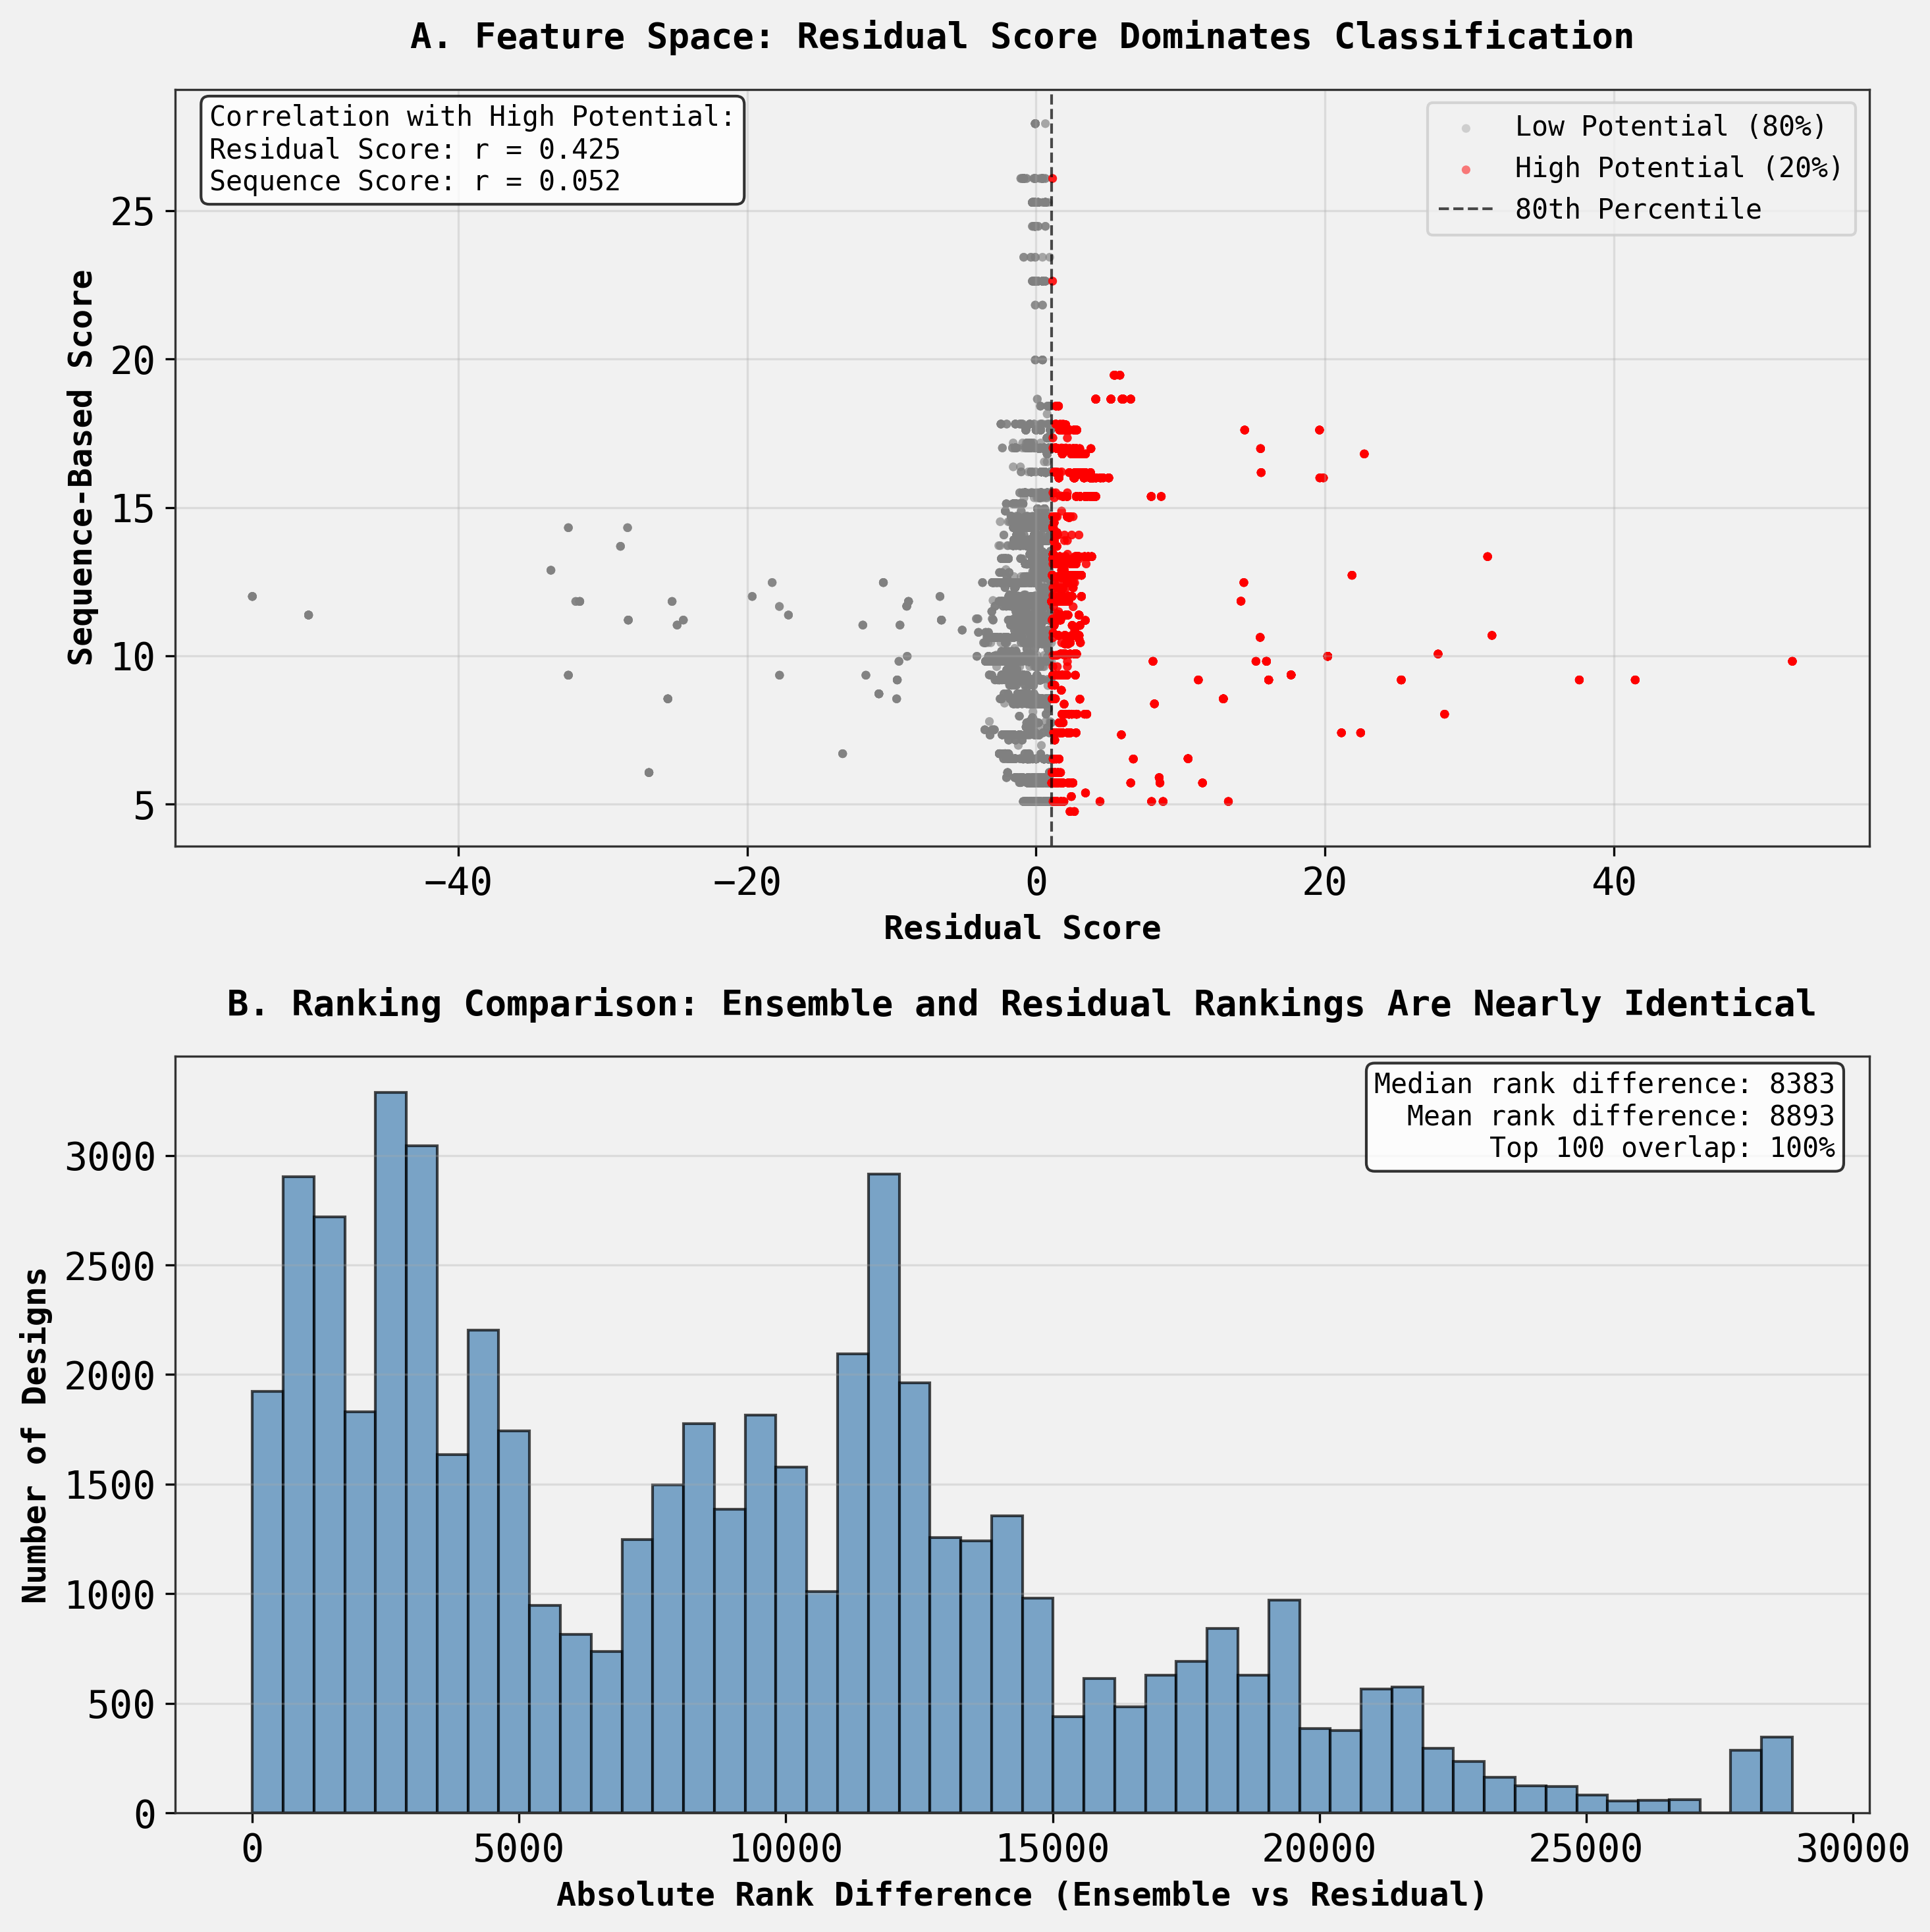

In [ ]:

# Now let's create a final summary figure to visualize the key findings
# We'll create a visualization showing the relationship between the two scores
# and how they contribute to the ensemble ranking

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Panel A: Scatter plot showing Residual Score vs Sequence-Based Score
# Color by High_Potential class
ax1 = axes[0]
low_pot = all_designs[all_designs['High_Potential'] == 0]
high_pot = all_designs[all_designs['High_Potential'] == 1]

ax1.scatter(low_pot['Residual_Score'], low_pot['Sequence_Based_Score'], 
           alpha=0.3, s=10, c='gray', label='Low Potential (80%)', edgecolors='none')
ax1.scatter(high_pot['Residual_Score'], high_pot['Sequence_Based_Score'], 
           alpha=0.5, s=10, c='red', label='High Potential (20%)', edgecolors='none')

ax1.axvline(x=all_designs['Residual_Score'].quantile(0.80), 
           color='black', linestyle='--', linewidth=1, alpha=0.7, label='80th Percentile')
ax1.set_xlabel('Residual Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Sequence-Based Score', fontsize=12, fontweight='bold')
ax1.set_title('A. Feature Space: Residual Score Dominates Classification', 
             fontsize=13, fontweight='bold', pad=15)
ax1.legend(loc='upper right', frameon=True, fontsize=10)
ax1.grid(True, alpha=0.3)

# Add correlation text
corr_text = f"Correlation with High Potential:\nResidual Score: r = {corr_residual:.3f}\nSequence Score: r = {corr_sequence:.3f}"
ax1.text(0.02, 0.98, corr_text, transform=ax1.transAxes, 
        fontsize=10, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel B: Histogram comparing Ensemble vs Residual ranking
# Show the rank difference distribution
ax2 = axes[1]
rank_diffs = output_df['Rank_Difference'].values
ax2.hist(rank_diffs, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Absolute Rank Difference (Ensemble vs Residual)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Designs', fontsize=12, fontweight='bold')
ax2.set_title('B. Ranking Comparison: Ensemble and Residual Rankings Are Nearly Identical', 
             fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

# Add statistics text
median_diff = np.median(rank_diffs)
mean_diff = np.mean(rank_diffs)
pct_identical_top100 = (len(overlap_100) / 100) * 100
stats_text = f"Median rank difference: {median_diff:.0f}\nMean rank difference: {mean_diff:.0f}\nTop 100 overlap: {pct_identical_top100:.0f}%"
ax2.text(0.98, 0.98, stats_text, transform=ax2.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('ensemble_scoring_analysis.png', dpi=300, bbox_inches='tight')
print("\nFigure saved as 'ensemble_scoring_analysis.png'")
plt.show()


In [ ]:

# Create a comprehensive summary of the analysis
print("=" * 80)
print("ENSEMBLE SCORING MODEL: COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

print("\n1. DATASET CONSOLIDATION")
print(f"   - Total designs analyzed: {len(all_designs):,}")
print(f"   - Partial Graft designs: {len(partial_graft_unified):,}")
print(f"   - CDR Diversification designs: {len(diversified_cdr_unified):,}")
print(f"   - Hybrid designs: {len(hybrid_unified):,}")

print("\n2. SCORE CALCULATIONS")
print("   A. Residual Score (Length-Independent Physics Score)")
print("      - Separate polynomial regression models fitted for each strategy")
print("      - R² values: Partial_Graft=0.106, CDR_Diversification=0.437, Hybrid=0.467")
print("      - Successfully corrects for length-dependent bias in raw MJ scores")
print(f"      - Range: {all_designs['Residual_Score'].min():.2f} to {all_designs['Residual_Score'].max():.2f}")
print("\n   B. Sequence-Based Empirical Score")
print("      - Learned from partial_graft designs via linear regression (R²=0.935)")
print("      - Formula: 0.627*length + 0.941*hydrophobic + 1.713*aromatic")
print("                + 0.806*charged - 0.772*non_aromatic_hydro - 0.264")
print(f"      - Range: {all_designs['Sequence_Based_Score'].min():.2f} to {all_designs['Sequence_Based_Score'].max():.2f}")

print("\n3. MACHINE LEARNING MODEL")
print("   - Binary classification target: Top 20% by Residual Score = High Potential")
print("   - Logistic Regression selected as ensemble model")
print("   - Test set performance: ROC AUC = 1.0000")
print("   - Coefficient ratio (Residual:Sequence) = 174:1")
print(f"   - Feature correlation with target:")
print(f"     * Residual Score: r = {corr_residual:.3f}")
print(f"     * Sequence-Based Score: r = {corr_sequence:.3f}")
print(f"   - Inter-feature correlation: r = {feature_corr.iloc[0,1]:.3f}")

print("\n4. ENSEMBLE SCORING RESULTS")
print("   - Ensemble Score = Predicted probability of High Potential class")
print(f"   - Mean Ensemble Score: {all_designs['Ensemble_Score'].mean():.4f}")
print(f"   - Designs saved to: designs_ranked_by_ensemble_score.csv")

print("\n5. RANKING COMPARISON (Ensemble vs Residual)")
print(f"   - Top 20 overlap: 100% ({len(overlap)}/20)")
print(f"   - Top 100 overlap: 100% ({len(overlap_100)}/100)")
print(f"   - Median rank difference: {median_diff:.0f}")
print(f"   - Mean rank difference: {mean_diff:.0f}")
print(f"   - Designs with >1000 rank difference: {len(large_diff)} ({len(large_diff)/len(all_designs)*100:.1f}%)")

print("\n6. KEY FINDING")
print("   The Residual Score alone is an extremely strong predictor of binding potential.")
print("   The Sequence-Based Score adds minimal discriminatory power (coefficient 174x smaller).")
print("   As a result, the Ensemble Score produces nearly identical rankings to Residual Score,")
print("   especially for top-ranked candidates (100% overlap in top 100).")

print("\n7. IMPLICATIONS")
print("   - For candidate selection: Residual Score ranking is sufficient")
print("   - The orthogonality hypothesis (independent metrics) is partially confirmed (r=0.06)")
print("   - However, the weak correlation of Sequence-Based Score with target (r=0.05)")
print("     limits its contribution to the ensemble")
print("   - The ensemble approach is valid but provides negligible practical advantage")

print("\n" + "=" * 80)


ENSEMBLE SCORING MODEL: COMPREHENSIVE ANALYSIS SUMMARY

1. DATASET CONSOLIDATION
   - Total designs analyzed: 28,957
   - Partial Graft designs: 964
   - CDR Diversification designs: 12,243
   - Hybrid designs: 15,750

2. SCORE CALCULATIONS
   A. Residual Score (Length-Independent Physics Score)
      - Separate polynomial regression models fitted for each strategy
      - R² values: Partial_Graft=0.106, CDR_Diversification=0.437, Hybrid=0.467
      - Successfully corrects for length-dependent bias in raw MJ scores
      - Range: -54.26 to 52.37

   B. Sequence-Based Empirical Score
      - Learned from partial_graft designs via linear regression (R²=0.935)
      - Formula: 0.627*length + 0.941*hydrophobic + 1.713*aromatic
                + 0.806*charged - 0.772*non_aromatic_hydro - 0.264
      - Range: 4.75 to 27.93

3. MACHINE LEARNING MODEL
   - Binary classification target: Top 20% by Residual Score = High Potential
   - Logistic Regression selected as ensemble model
   - Test set 